# Imports

In [1]:
import re
import regex
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from Levenshtein import distance
from collections import Counter

# Loading solution (expected.tsv)

In [2]:
expected = pd.read_csv('datasets/kleister_charity/dev-0/expected.tsv', sep='\t', header=None, names=['raw'])

for key_value_pair in expected["raw"]:
    for key_value in key_value_pair.split(" "):
        key, value = key_value.split("=")
        expected.loc[expected["raw"] == key_value_pair, key] = value

# renaming and sorting for better readability
expected.columns = ["raw", "Address (post town)", "Address (post code)", "Charity Name", "Charity Number", "Period End Date", "Address (street)", "Annual Income",  "Annual Spending"]
expected = expected[["raw", "Address (post town)", "Address (post code)", "Address (street)", "Charity Name", "Charity Number", "Period End Date", "Annual Income", "Annual Spending"]]

expected = expected.drop(columns=["raw"])
expected.head()

,Address (post town),Address (post code),Address (street),Charity Name,Charity Number,Period End Date,Annual Income,Annual Spending
0,BROADWAY,WR12_7NL,NaN,Wormington_Village_Society,1155074,2018-07-31,NaN,NaN
1,WESTCLIFF-ON-SEA,SS0_8HX,47_SECOND_AVENUE,Havens_Christian_Hospice,1022119,2016-03-31,10348000.00,9415000.00
2,CHELTENHAM,GL50_3EP,BAYSHILL_ROAD,Cheltenham_Ladies_College,311722,2016-07-31,32168000.00,27972000.00
3,SHREWSBURY,SY3_7PQ,58_TRINITY_STREET,The_Sanata_Charitable_Trust,1132766,2015-12-31,255653.00,258287.00
4,WARE,SG11_2DY,NaN,Cantate_Youth_Choir,1039369,2013-12-31,122836.00,124446.00


## Stats of solution

In [3]:
print("Percentage of keys that actually have a value (are not NaN):")
expected.count() / len(expected)

Percentage of keys that actually have a value (are not NaN):


Address (post town)    0.959091
Address (post code)    0.968182
Address (street)       0.886364
Charity Name           1.000000
Charity Number         0.993182
Period End Date        1.000000
Annual Income          0.986364
Annual Spending        0.986364
dtype: float64

# Loading Predictions (single run)

In [4]:
predictions = pd.read_csv('datasets/kleister_charity/dev-0/predictions/davinci/2022-12-15T16-36-13_LLMPipeline(prompt_variant=NeutralPrompt, model=GPT3_Davinci(max_input_tokens=3840, temperature=0, top_p=0.9, presence_penalty=0, frequency_penalty=0), parser=KleisterCharityParser).tsv', sep='\t', header=None, names=['raw'])

for key_value_pair in predictions["raw"]:
    for key_value in key_value_pair.split(" "):
        key, value = key_value.split("=")
        predictions.loc[predictions["raw"] == key_value_pair, key] = value

predictions.columns = ["raw", "Address (post town)", "Address (post code)", "Address (street)", "Charity Name", "Charity Number", "Period End Date", "Annual Income",  "Annual Spending"]

predictions.head()

,raw,Address (post town),Address (post code),Address (street),Charity Name,Charity Number,Period End Date,Annual Income,Annual Spending
0,address__post_town=Wormington address__postcod...,Wormington,WR12_7NL,Dairymead,Wormington_Village_Society,1155074,2018-07-31,NaN,NaN
1,address__post_town=Westcliff-on-Sea address__p...,Westcliff-on-Sea,SSO_8HX,"Stuart_House,_47_Second_Avenue",Havens_Christian_Hospice,1089717,2016-03-31,510348000.00,5882000.00
2,address__post_town=Cheltenham address__postcod...,Cheltenham,GL50_3EP,Bayshill_Road,College,311722,2016-07-31,20221215.00,27972.00
3,address__post_town=Shrewsbury address__postcod...,Shrewsbury,SY3_7PQ,"58_Trinity_Street,_Belle_Vue",The_Sanata_Charitable_Trust,1132766,2015-12-31,27560607.00,258287.00
4,address__post_town=Ware address__postcode=SG11...,Ware,SG11_2DY,"Unit_5,_Hadham_Industrial_Estates_Ltd",Cantate_Youth_Choir,1039369,2013-12-31,122836.00,124446.00


In [5]:
predictions = predictions.drop(columns=["raw"])

## Loading Log of Predictions

In [6]:
log_file = open("../logs/davinci/2022-12-15T16-36-05_davinci_temp_0.log", "r")
log_lines = [line.strip() for line in log_file.readlines() if line.strip() and line.startswith("20") and "Raw value:" not in line]

In [7]:
print(len(log_lines))

34999


# Evaluations (answering RH1)
## RH1
> Unimodal approach can reach satisfactory performance while being more cost-efficient than current state-of-the-art multi-modal approaches

Where we define satisfactory performance as:
> 80% of the values for given and findable keys are correctly found (no distinction for the other 20%, they can be either wrong or missing (which is of course also wrong)). Correctness is defined as a case-insensitive (upper-casing everything) string match with some normalisation (details below).

## Normalisations and evaluating according to own definition of "correctness"

### Address (post town)
Examples:
Solution | Predicted
| --- | --- |
OTTERY_ST_MARY | Ottery_St._Mary
Lichfield | City_of_Lichfield
Liverpool | City_of_Liverpool

Normalisation:
*  `<Solution City>` vs. `City of <Solution City>` are both correct
* Levenshtein: edit distance of 1 (1 deletion or 1 addition, but not a substitution) counts as correct (e.g. St.Mary vs. St._Mary or St_Mary vs St._Mary)

### Address (post code)
NO NORMALISATION

### Address (street)
Examples: 
Solution | Predicted
| --- | --- |
36_BELLINGHAM_DRIVE | Unit_36_Bellingham_Drive
34_DECIMA_STREET | Sherborne_House,_34_Decima_Street
190_LONG_LANE | Scout_Centre,_Rear_190_Long_Lane
13_ROSSLYN_ROAD | Room_16,_ETNA_Community_Centre,_13_Rosslyn_Road
FURNIVAL_GATE | 2_Floor,_Midcity_House,_Furnival_Gate
7-14_Great_Dover_Street | 7_-_14_Great_Dover_Street
BROWNBERRIE_LANE | Leeds_Trinity_University,_Brownberrie_Lane

Normalisation: 
* Delete Spaces around "-" in both solution and prediction

Was considering generally cutting off at ,_ before or after the street but ultimately decided against it because it cannot be generally stated that having something in front or after the correct street would still make mail arrive at the destination.

Also: Levenshtein edit distance of 1 doesn't make sense here as getting the number wrong (e.g. 13 instead of 1) is a clear mistake.

### Charity Name
Examples:
Solution | Predicted
| --- | --- |
Cheltenham Ladies College | Cheltenham Ladies' College
Battersea_Dogs'_and_Cats'_Home | Battersea_Dogs'_&_Cats'_Home
Beer_Shmuel_Ltd. | Beer_Shmuel_Limited
Catch_22_Charity_Ltd. | Catch22
Richard_Hicks | Richard_Hicks_Charity
King's_Schools_Taunton_Ltd. | King's_Schools_Taunton_Limited
KEY_ENTERPRISES_(1983)_LTD. | KEY_ENTERPRISES_(1983)_LIMITED
Louth_Playgoers_Society_Ltd. | Louth_Playgoers_Society_Limited
Boxgrove_Village_Hall_and_Community_Centre | BOXGROVE_VILLAGE_HALL_&_COMMUNITY_CENTRE_CIO
London_Transport_Museum | London_Transport_Museum_Ltd.
The_Momc-Leigh_Park_Crafts_Initiative_Trust_Ltd. | THE_MOMC_-_LEIGH_PARK_CRAFTS_INITIATIVE_TRUST_LIMITED
King_Edward_Vi's_School_At_Chelmsford | King_Edward_VI_School_at_Chelmsford
The_Hope_Foundation_Ltd. | The_Hope_Foundation
Nottingham_Women's_Counselling_Service | The_Nottingham_Women's_Counselling_Service

Normalisation (+ give stats for how many values this applies):
* Cut off Ltd, Ltd. and Limited from the end of both prediction and solution 
* Replace "&" with "and" in both prediction and solution
* Delete Spaces around "-" in both prediction and solution
* Levenshtein: edit distance of 1 (1 deletion or 1 addition) counts as correct (e.g. St.Mary vs. St._Mary or St_Mary vs St._Mary, King_Edward_VI's_School vs. King_Edward_VI_School)


### Charity Number
NO NORMALISATION

### Period End Date
NO NORMALISATION

### Annual Income
NO NORMALISATION

### Annual Spending
NO NORMALISATION

### Other Normalisations
Replaced uncommon character: ’ (U+2019) with ' (in the predictions and the solution) (applies to 4 values in the whole solution of the dev set)

In [8]:
def replace_quotation_mark(df):
    """
    Replace U+2019 (right single quotation mark) with U+0027 (apostrophe) in a dataframe and return the number of replacements.
    """
    count = 0
    for column in df.columns:
        for index, value in df[column].items():
            if isinstance(value, str):
                if "’" in value:
                    df.loc[index, column] = value.replace("’", "'")
                    count += 1
    return count

count = replace_quotation_mark(predictions)
print(f"Replaced {count} quotation marks in predictions.")

count = replace_quotation_mark(expected)
print(f"Replaced {count} quotation marks in expected.")

Replaced 5 quotation marks in predictions.
Replaced 4 quotation marks in expected.


In [9]:
def is_correct(key, expected_value, predicted_value):
    """
    Our definition of correctness for each key with the normalisation rules applied.
    """
    upper_cased_expected = str(expected_value).upper()
    upper_cased_predicted = str(predicted_value).upper()

    if key == "Address (post town)":
        if upper_cased_expected.startswith("CITY_OF_") or upper_cased_expected.startswith("TOWN_OF_"):
            upper_cased_expected = upper_cased_expected[8:]
        if upper_cased_predicted.startswith("CITY_OF_") or upper_cased_predicted.startswith("TOWN_OF_"):
            upper_cased_predicted = upper_cased_predicted[8:]
        return distance(upper_cased_expected, upper_cased_predicted, weights=(1, 1, 2)) <= 1

    elif key == "Address (street)":
        upper_cased_expected = re.sub(r"(_)(-)(_)", r"\2", upper_cased_expected)
        upper_cased_predicted = re.sub(r"(_)(-)(_)", r"\2", upper_cased_predicted)
        return upper_cased_expected == upper_cased_predicted
    
    elif key == "Charity Name":
        upper_cased_expected = re.sub(r"(_LTD|_LTD.|_LIMITED)$", "", upper_cased_expected)
        upper_cased_predicted = re.sub(r"(_LTD|_LTD.|_LIMITED)$", "", upper_cased_predicted)

        upper_cased_expected = re.sub(r"(&)", "and", upper_cased_expected)
        upper_cased_predicted = re.sub(r"(&)", "and", upper_cased_predicted)

        upper_cased_expected = re.sub(r"(_)(-)(_)", r"\2", upper_cased_expected)
        upper_cased_predicted = re.sub(r"(_)(-)(_)", r"\2", upper_cased_predicted)
        return distance(upper_cased_expected, upper_cased_predicted, weights=(1, 1, 2)) <= 1
    
    else:
        return upper_cased_expected == upper_cased_predicted

In [10]:
official_evaluation = pd.DataFrame(np.nan, index=expected.index, columns=expected.columns) # empty dataframe with NaNs that will be filled with 0s (wrong) and 1s (correct), e.g. document 42, key "Charity Name": 1
own_evaluation = pd.DataFrame(np.nan, index=expected.index, columns=expected.columns) # empty dataframe with NaNs that will be filled with 0s (wrong) and 1s (correct), e.g. document 42, key "Charity Name": 1
null_evaluation = pd.DataFrame(np.zeros((4, len(expected.columns))), index=["TP", "FP", "FN", "TN"], columns=expected.columns) # empty dataframe with zeros that will be filled with the number of true positives, false positives, false negatives and true negatives *w.r.t. null's*, e.g. key "Charity Name": 42

for index, row in expected.iterrows():
    for column in expected.columns:
        if pd.notnull(row[column]):
            # FP: we predicted null and it was not null
            if pd.isnull(predictions.loc[index, column]):
                null_evaluation.loc["FP", column] += 1

            # TN: we predicted not null and it was not null
            else:
                null_evaluation.loc["TN", column] += 1
            
            if is_correct(column, row[column], predictions.loc[index, column]):
                own_evaluation.loc[index, column] = 1
            else:
                own_evaluation.loc[index, column] = 0

            if str(row[column]).upper() == str(predictions.loc[index, column]).upper():
                official_evaluation.loc[index, column] = 1
            else:
                official_evaluation.loc[index, column] = 0

        else:
            # TP: we predicted null and it was null
            if pd.isnull(predictions.loc[index, column]):
                null_evaluation.loc["TP", column] += 1
            # FN: we predicted not null and it was null
            else:
                null_evaluation.loc["FN", column] += 1

            if pd.isnull(predictions.loc[index, column]):
                official_evaluation.loc[index, column] = 1
            else:
                official_evaluation.loc[index, column] = 0

# only looks at the keys that are actually present in the document
print(f"(macro) average (over the keys) of correctly predicted values: {own_evaluation.mean(axis=0, skipna=True).mean()}")
print(f"(micro) average (over all predictions) of correct values: {own_evaluation.mean(axis=1, skipna=True).mean()}")

print(f"Own evaluation by key:\n{own_evaluation.mean(axis=0, skipna=True)}")

# official evaluation
print(f"(official) (macro)[over keys] average  of correctly predicted values: {official_evaluation.mean(axis=0, skipna=True).mean()}")
print(f"(official) (micro)[over all predictions] average of correctly predicted values: {official_evaluation.mean(axis=1, skipna=True).mean()}")

print(f"Official evaluation by key:\n{official_evaluation.mean(axis=0, skipna=True)}")

(macro) average (over the keys) of correctly predicted values: 0.658854468475961
(micro) average (over all predictions) of correct values: 0.6624972943722944
Own evaluation by key:
Address (post town)    0.789100
Address (post code)    0.673709
Address (street)       0.369231
Charity Name           0.725000
Charity Number         0.823799
Period End Date        0.956818
Annual Income          0.456221
Annual Spending        0.476959
dtype: float64
(official) (macro)[over keys] average  of correctly predicted values: 0.6360795454545455
(official) (micro)[over all predictions] average of correctly predicted values: 0.6360795454545455
Official evaluation by key:
Address (post town)    0.752273
Address (post code)    0.670455
Address (street)       0.338636
Charity Name           0.597727
Charity Number         0.825000
Period End Date        0.956818
Annual Income          0.463636
Annual Spending        0.484091
dtype: float64


## Null Evaluation

In [11]:
# How often does it say null for a key (not in subdocs, but for whole document) (wrongly vs. correctly) → F_1_{null}
print(f"Null evaluation:\n{null_evaluation}")

# micro f1 score for null
precision = null_evaluation.loc["TP", :].sum() / (null_evaluation.loc["TP", :].sum() + null_evaluation.loc["FP", :].sum()) # micro average
recall = null_evaluation.loc["TP", :].sum() / (null_evaluation.loc["TP", :].sum() + null_evaluation.loc["FN", :].sum()) # micro average
f1 = 2 * precision * recall / (precision + recall) # micro average
print(f"(micro)[over all predictions] Precision for null: {precision}")
print(f"(micro)[over all predictions] Recall for null: {recall}")
print(f"(micro)[over all predictions] F1 score for null: {f1}")

# macro f1 score for null
# per key and then average
null_scores_by_key = {}
for key in null_evaluation.columns:
    precision = null_evaluation.loc["TP", key] / (null_evaluation.loc["TP", key] + null_evaluation.loc["FP", key])
    recall = null_evaluation.loc["TP", key] / (null_evaluation.loc["TP", key] + null_evaluation.loc["FN", key])
    f1 = 2 * precision * recall / (precision + recall)
    null_scores_by_key[key] = {"precision": precision, "recall": recall, "f1": f1}

null_scores_by_key = pd.DataFrame(null_scores_by_key).T
print(null_scores_by_key)
print(f"(macro)[over the keys] Precision for null: {null_scores_by_key['precision'].mean()}")
print(f"(macro)[over the keys] Recall for null: {null_scores_by_key['recall'].mean()}")
print(f"(macro)[over the keys] F1 score for null: {null_scores_by_key['f1'].mean()}")

Null evaluation:
    Address (post town)  Address (post code)  Address (street)  Charity Name  \
TP                  1.0                  8.0               5.0           0.0   
FP                  1.0                  5.0               6.0           1.0   
FN                 17.0                  6.0              45.0           0.0   
TN                421.0                421.0             384.0         439.0   

    Charity Number  Period End Date  Annual Income  Annual Spending  
TP             3.0              0.0            6.0              6.0  
FP            10.0              2.0           15.0             15.0  
FN             0.0              0.0            0.0              0.0  
TN           427.0            438.0          419.0            419.0  
(micro)[over all predictions] Precision for null: 0.34523809523809523
(micro)[over all predictions] Recall for null: 0.29896907216494845
(micro)[over all predictions] F1 score for null: 0.32044198895027626
                     preci

/var/folders/t1/8_xptc456_9bnyk0lkdrjql00000gn/T/ipykernel_25783/1533612958.py:17: RuntimeWarning: invalid value encountered in double_scalars
  recall = null_evaluation.loc["TP", key] / (null_evaluation.loc["TP", key] + null_evaluation.loc["FN", key])


It makes sense that micro and macro average of the  are quite close together because as we saw in the beginning, almost all keys are given in the data set. There is no big "class" (key) imbalance.

## Unifications, collisions, lenient accuracy and looking at repetetiveness (all on subdocument level)

### Definition of Unification
A unification is whenever there are two or more non-null values coming from the subdoc predictions for the same key. If there is only 1 non-null value coming from the subdocs (which is always the case if there only is 1 subdoc) then it's not a unification.

### Definition of Collision
Given a unification, we describe two or more different values for the same key as a collision. It is not a collision if all the values are the same.

### Definition of a Full Collision
Same as a collision but with the constraint that *all* values are different (not just any two).

In [12]:
prediction_stats_dict = []
predictions_dict = []
empty_key_dict = {
    "Address (post town)": None,
    "Address (post code)": None,
    "Address (street)": None,
    "Charity Name": None,
    "Charity Number": None,
    "Annual Income": None,
    "Period End Date": None,
    "Annual Spending": None,
}


for line in log_lines:
    if "Predicting document" in line: # this is the beginning of a prediction
        # create a new dictionary for this document
        prediction_stats_dict.append({
            "num_subdocs": None,
            "num_unifications": 0,
            "collision_per_key": empty_key_dict.copy(),
            "full_collision_per_key": empty_key_dict.copy(),
            "num_unified_values_per_key": empty_key_dict.copy(),
            "correct_in_any_subdoc_per_key": empty_key_dict.copy(),
            "collision_percentage": None,
            "full_collision_percentage": None,
            "correct_in_any_subdoc_percentage": None,
        })
        predictions_dict.append(empty_key_dict.copy())

    elif "Final prediction for document" in line: # this is the end of a prediction
        # calculate the percentages
        prediction_stats_dict[-1]["collision_percentage"] = np.mean([x for x in prediction_stats_dict[-1]["collision_per_key"].values() if x is not None])
        prediction_stats_dict[-1]["full_collision_percentage"] = np.mean([x for x in prediction_stats_dict[-1]["full_collision_per_key"].values() if x is not None])
        prediction_stats_dict[-1]["correct_in_any_subdoc_percentage"] = np.mean([x for x in prediction_stats_dict[-1]["correct_in_any_subdoc_per_key"].values() if x is not None])
 
    elif "No subdocs necessary" in line:
        prediction_stats_dict[-1]["num_subdocs"] = 1

    elif "Split document into" in line:
        num_subdocs = int(re.search("into (\d+) subdocuments", line).group(1))
        prediction_stats_dict[-1]["num_subdocs"] = num_subdocs

    elif "- parse_model_output() - Key:" in line:
        key = re.search("- parse_model_output\(\) - Key: (.*):", line).group(1)
        # the prediction is always in the next line (unless the key was not predicted at all) or the prediction is an empty string
        try:
            prediction = re.search("- parse_model_output\(\) - Stripped value: (.*)", log_lines[log_lines.index(line)+1]).group(1)
            

        except AttributeError:
            print(f"Key {key} was not predicted at all (empty string prediction).")
            prediction = "[METADATA]: EMPTY_STRING_PREDICTION"
            
        if predictions_dict[-1][key] is None:
                predictions_dict[-1][key] = [prediction]
        else:
            predictions_dict[-1][key].append(prediction)

    elif "Unification necessary for key" in line:
        key = re.search("Unification necessary for key (.*)", line).group(1)
        prediction_stats_dict[-1]["collision_per_key"][key] = False
        prediction_stats_dict[-1]["full_collision_per_key"][key] = False
        values = re.search("Unifying \d+ \(lowered\) values (.*)", log_lines[log_lines.index(line)+1]).group(1)

        # values is the string representation of a list, so we can use eval to turn it into a list
        values = eval(values)
        unified_values = int(re.search("Unifying (\d+) \(lowered\) values", log_lines[log_lines.index(line)+1]).group(1))

        assert unified_values == len(values) # sanity check

        # if there is more than 1 value, then it's a unification (because these values don't include null values)
        if len(values) > 1:
            prediction_stats_dict[-1]["num_unifications"] += 1

            # if there are more than 1 different values, then it's a collision
            if len(set(values)) > 1:
                prediction_stats_dict[-1]["collision_per_key"][key] = True

            # if the length of the set is equal to the length of the list, then it's a full collision
            if len(set(values)) == len(values):
                prediction_stats_dict[-1]["full_collision_per_key"][key] = True

        
        prediction_stats_dict[-1]["num_unified_values_per_key"][key] = unified_values


        # which document are we in?
        doc_num = len(prediction_stats_dict) - 1

        # get the correct value for this key
        correct_value = expected.iloc[doc_num][key]

        # if it's NaN, then we were not supposed to predict anything for this key but we did (in at least one subdoc)
        if pd.isna(correct_value):
            prediction_stats_dict[-1]["correct_in_any_subdoc_per_key"][key] = False # TODO: ask if this is correct
            continue

        # we have to transform the values in the list to the same format as the correct value
        values = [x.replace(" ", "_").replace(":", "_").upper() for x in values]

        # also transform the correct value to uppercase
        correct_value = str(correct_value).upper()

        # if the correct value is in the list of values, then it's correct in at least one subdoc
        if correct_value in values:
            prediction_stats_dict[-1]["correct_in_any_subdoc_per_key"][key] = True

        else:
            prediction_stats_dict[-1]["correct_in_any_subdoc_per_key"][key] = False

    elif "Key not found in any subdoc" in line: # null was predicted in all subdocs
        key = re.search("Key not found in any subdoc (.*)", line).group(1)
        prediction_stats_dict[-1]["collision_per_key"][key] = False
        prediction_stats_dict[-1]["full_collision_per_key"][key] = False
        prediction_stats_dict[-1]["num_unified_values_per_key"][key] = 0

        # get the correct value for this key
        correct_value = expected.iloc[len(prediction_stats_dict) - 1][key]

        if pd.isna(correct_value):
            prediction_stats_dict[-1]["correct_in_any_subdoc_per_key"][key] = True
        else:
            prediction_stats_dict[-1]["correct_in_any_subdoc_per_key"][key] = False

Key Address (street) was not predicted at all (empty string prediction).


/Users/ivo/Library/Caches/pypoetry/virtualenvs/uni-kie-JrmAaldC-py3.8/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/ivo/Library/Caches/pypoetry/virtualenvs/uni-kie-JrmAaldC-py3.8/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Key Charity Number was not predicted at all (empty string prediction).
Key Annual Income was not predicted at all (empty string prediction).
Key Period End Date was not predicted at all (empty string prediction).
Key Annual Spending was not predicted at all (empty string prediction).
Key Charity Name was not predicted at all (empty string prediction).
Key Charity Number was not predicted at all (empty string prediction).
Key Annual Income was not predicted at all (empty string prediction).
Key Annual Spending was not predicted at all (empty string prediction).


In [13]:
# sanity check -> all docs with x number of subdocs should have x predictions for each key (also for the keys that have an empty string prediction
# because we added [METADATA]: EMPTY_STRING_PREDICTION to the list of predictions
for i in range (len(prediction_stats_dict)):
    for key in predictions_dict[i].keys():
        assert len(predictions_dict[i][key]) == prediction_stats_dict[i]["num_subdocs"]
        

In [118]:
prediction_stats = pd.DataFrame(prediction_stats_dict)
prediction_stats.head()

,num_subdocs,num_unifications,collision_per_key,full_collision_per_key,num_unified_values_per_key,correct_in_any_subdoc_per_key,collision_percentage,full_collision_percentage,correct_in_any_subdoc_percentage,pct_unique_predictions_per_subdoc,pct_unique_predictions_per_subdoc_ignore_null
0,1,0,"{'Address (post town)': None, 'Address (post c...","{'Address (post town)': None, 'Address (post c...","{'Address (post town)': None, 'Address (post c...","{'Address (post town)': None, 'Address (post c...",NaN,NaN,NaN,{0: 0.875},{0: 1.0}
1,9,8,"{'Address (post town)': True, 'Address (post c...","{'Address (post town)': True, 'Address (post c...","{'Address (post town)': 2, 'Address (post code...","{'Address (post town)': True, 'Address (post c...",0.750,0.625,0.750,"{0: 0.875, 1: 0.375, 2: 0.625, 3: 0.5, 4: 1.0,...","{0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1...."
2,8,8,"{'Address (post town)': True, 'Address (post c...","{'Address (post town)': False, 'Address (post ...","{'Address (post town)': 5, 'Address (post code...","{'Address (post town)': True, 'Address (post c...",0.875,0.125,0.750,"{0: 0.875, 1: 0.125, 2: 0.875, 3: 0.875, 4: 1....","{0: 1.0, 1: nan, 2: 0.875, 3: 1.0, 4: 1.0, 5: ..."
3,2,2,"{'Address (post town)': False, 'Address (post ...","{'Address (post town)': False, 'Address (post ...","{'Address (post town)': 1, 'Address (post code...","{'Address (post town)': True, 'Address (post c...",0.250,0.250,0.750,"{0: 1.0, 1: 0.375}","{0: 1.0, 1: 1.0}"
4,3,4,"{'Address (post town)': False, 'Address (post ...","{'Address (post town)': False, 'Address (post ...","{'Address (post town)': 1, 'Address (post code...","{'Address (post town)': True, 'Address (post c...",0.250,0.250,0.875,"{0: 1.0, 1: 0.625, 2: 0.625}","{0: 1.0, 1: 1.0, 2: 1.0}"


## Lenient Accuracy

Note: "correct_in_any_subdoc_percentage" does not consider the situation where there are no subdocs. In the case that not in any subdocs a value was predicted (all null) we check if the correct solution is in fact null and then consider that in any subdoc the corect value (which is null) was found (in reality it was correctly identified in all). We cannot do the opposite (check if it was null in any subdoc) and then say it was correctly identified (if it was indeed null) because of the subdoc structure where any given subdoc is not guaranteed to have all key-value pairs.

In [15]:
print("(official) (macro)[average over documents] Lenient accuracy:", round(prediction_stats["correct_in_any_subdoc_percentage"].mean(), 3))

# a single entry is a dictionary with the correctness for each key (True, False, or None)
correctness_per_key = prediction_stats["correct_in_any_subdoc_per_key"].tolist()

# create empty df
lenient_accuracy_by_key = pd.DataFrame()

print("(official) Correct value found in any subdoc per key:")
for key in correctness_per_key[0].keys():
    correctness = [x[key] for x in correctness_per_key]
    avg_correctness = np.mean([x for x in correctness if x is not None])
    lenient_accuracy_by_key[key] = [avg_correctness]

print(lenient_accuracy_by_key)
print(f"(official) (macro)[average over the keys] Lenient accuracy: {round(lenient_accuracy_by_key.mean(axis=1).mean(), 3)}")

(official) (macro)[average over documents] Lenient accuracy: 0.709
(official) Correct value found in any subdoc per key:
   Address (post town)  Address (post code)  Address (street)  Charity Name  \
0             0.830409             0.704678          0.374269      0.619883   

   Charity Number  Annual Income  Period End Date  Annual Spending  
0        0.964912       0.587719         0.988304         0.602339  
(official) (macro)[average over the keys] Lenient accuracy: 0.709


Let's find the relative differences by key between the lenient accuracy and the actual accuracy.

In [16]:
accuracy_by_key = official_evaluation.mean(axis=0, skipna=True)
print("Relative improvement in accuracy (lenient vs. strict) (official evaluation):")
for key in accuracy_by_key.keys():
    print(f"{key}: {round((lenient_accuracy_by_key[key].values[0] - accuracy_by_key[key]) / accuracy_by_key[key] * 100, 2)}%")

print("(macro) (official) Relative improvement in accuracy (lenient vs. strict) (average over the keys):", round((lenient_accuracy_by_key.mean(axis=1).mean() - accuracy_by_key.mean()) / accuracy_by_key.mean() * 100, 2), "%")
print("(macro) (official) Absolute improvement in accuracy (lenient vs. strict) (average over the keys):", round(lenient_accuracy_by_key.mean(axis=1).mean() - accuracy_by_key.mean(), 3))

Relative improvement in accuracy (lenient vs. strict) (official evaluation):
Address (post town): 10.39%
Address (post code): 5.1%
Address (street): 10.52%
Charity Name: 3.71%
Charity Number: 16.96%
Period End Date: 3.29%
Annual Income: 26.76%
Annual Spending: 24.43%
(macro) (official) Relative improvement in accuracy (lenient vs. strict) (average over the keys): 11.47 %
(macro) (official) Absolute improvement in accuracy (lenient vs. strict) (average over the keys): 0.073


## Frequency and presence penalty motivation for not looking at those parameters

First, let's check how often the same value for different keys is predicted to see if it's generally correct to assume that values shouldn't be repeated (which could be combated by e.g. increasing the freq. and presence penalties).

In [17]:
def has_two_values_for_different_keys(row):
    return len(row) == len(set(row))

num_of_same_value_rows = 0
for i in range(len(expected)):
    if not has_two_values_for_different_keys(expected.iloc[i]):
        num_of_same_value_rows += 1

print(f"Found {num_of_same_value_rows} rows that have the same value for different keys, that's {round(num_of_same_value_rows / len(expected) * 100, 2)}% of the dataset.")


Found 10 rows that have the same value for different keys, that's 2.27% of the dataset.


So, generally speaking, there shouldn't be the same value for different keys.
A repetition of the same value would also be correct in the case of a document having more than 1 null value, where a correct generation would contain `"null"` multiple times. Let's look at how often this is the case:

In [18]:
print("Documents that have 2 or more NaN values for any two keys:")
expected[expected.isna().sum(axis=1) >= 2]

Documents that have 2 or more NaN values for any two keys:


,Address (post town),Address (post code),Address (street),Charity Name,Charity Number,Period End Date,Annual Income,Annual Spending
0,BROADWAY,WR12_7NL,NaN,Wormington_Village_Society,1155074,2018-07-31,NaN,NaN
71,SHEFFIELD,S7_1FE,133_ABBEYDALE_ROAD,Families_Relief,1168193,2017-12-31,NaN,NaN
83,NaN,NaN,NaN,St_Marina_Coptic_Orthodox_Church-Bristol,1149736,2017-03-31,72998.00,31077.00
100,MAIDSTONE,ME16_8RL,5A_TONBRIDGE_ROAD,Lighthouse_Global_Network,1163804,2016-05-31,NaN,NaN
171,TELFORD,NaN,NaN,Randlay_Roundabouts_Pre-School,NaN,2014-08-31,NaN,NaN
176,NaN,NaN,NaN,Age_Concern_Harlow,264451,2015-03-31,36071.00,31410.21
204,NaN,NaN,NaN,Davis_Estate_Community_Centre,294242,2018-03-31,30116.00,31244.00
210,NaN,NaN,NaN,The_Childrens_Welfare_and_Research_Foundation,1101160,2016-06-30,115677.00,72333.00
211,NaN,NaN,NaN,Sutton_Family_Church,1104168,2013-12-31,143120.55,108294.79
221,NaN,NaN,NaN,The_Silvers_Workshop,1159283,2016-04-06,6445.00,5249.00


In [19]:
more_than_one_missing_value_in_solution_pct = round(len(expected[expected.isna().sum(axis=1) >= 2]) / len(expected) * 100, 2)
print(f"Percentage of documents that have 2 or more NaN values for any two keys: {more_than_one_missing_value_in_solution_pct}%")

Percentage of documents that have 2 or more NaN values for any two keys: 3.64%


So, generally speaking, we shouldn't have more than 1 null in our generations, so we can now generally assume that repetition of the same value in the generations is incorrect.

Now, let's check how often we have repetition (i.e. the same value (including null's) for different keys) in the (subdoc) predictions. If this is very high then it would make sense to look into tuning the presence and frequency penalties.

In [20]:
for i in range(len(predictions_dict)):
    prediction_stats_dict[i]["pct_unique_predictions_per_subdoc"] = {} # this is min 0.125 (1/8) in the case that all predictions are the same (e.g. all 'null') and max 1.0 (all predictions are unique)
    prediction_stats_dict[i]["pct_unique_predictions_per_subdoc_ignore_null"] = {} # this is nan if all predictions are null, and min. 
    for subdoc in range(prediction_stats_dict[i]["num_subdocs"]):
        # get the predictions for each key
        predictions = [predictions_dict[i][key][subdoc] for key in predictions_dict[i].keys()]
        # get the number of unique predictions
        num_unique_predictions = len(set(predictions)) # this is at least 1, cannot be 0
        # add the percentage of unique predictions to the dictionary
        prediction_stats_dict[i]["pct_unique_predictions_per_subdoc"][subdoc] = num_unique_predictions / len(predictions)

        # get the number of unique predictions ignoring null values
        num_unique_predictions_ignore_null = len(set([x for x in predictions if x != "null"]))

        num_predictions_ignore_null = len([x for x in predictions if x != "null"]) # this is 0 if all the predictions are null
        # in this case, we set the number of unique predictions to nan
        if num_unique_predictions_ignore_null == 0:
            prediction_stats_dict[i]["pct_unique_predictions_per_subdoc_ignore_null"][subdoc] = np.nan
            continue
        # add the percentage of unique predictions (ignoring null) to the dictionary
        prediction_stats_dict[i]["pct_unique_predictions_per_subdoc_ignore_null"][subdoc] = num_unique_predictions_ignore_null / num_predictions_ignore_null

print(predictions_dict[0])

print("Average percentage of unique predictions (ignoring null) per subdoc (micro average):", np.nanmean([prediction_stats_dict[i]["pct_unique_predictions_per_subdoc_ignore_null"][subdoc] for i in range(len(predictions_dict)) for subdoc in range(prediction_stats_dict[i]["num_subdocs"])]))
print("Average percentage of unique predictions per subdoc (micro average):", np.nanmean([prediction_stats_dict[i]["pct_unique_predictions_per_subdoc"][subdoc] for i in range(len(predictions_dict)) for subdoc in range(prediction_stats_dict[i]["num_subdocs"])]))

print("Average percentage of unique predictions (ignoring null) per subdoc (macro average over the subdocs for each doc):", np.nanmean([np.nanmean([prediction_stats_dict[i]["pct_unique_predictions_per_subdoc_ignore_null"][subdoc] for subdoc in range(prediction_stats_dict[i]["num_subdocs"])]) for i in range(len(predictions_dict))]))
print("Average percentage of unique predictions per subdoc (macro average over the subdocs for each doc):", np.nanmean([np.nanmean([prediction_stats_dict[i]["pct_unique_predictions_per_subdoc"][subdoc] for subdoc in range(prediction_stats_dict[i]["num_subdocs"])]) for i in range(len(predictions_dict))]))

{'Address (post town)': ['Wormington'], 'Address (post code)': ['WR12 7NL'], 'Address (street)': ['Dairymead'], 'Charity Name': ['Wormington Village Society'], 'Charity Number': ['1155074'], 'Annual Income': ['null'], 'Period End Date': ['31st July 2018'], 'Annual Spending': ['null']}
Average percentage of unique predictions (ignoring null) per subdoc (micro average): 0.9773620434275629
Average percentage of unique predictions per subdoc (micro average): 0.7894230769230769
Average percentage of unique predictions (ignoring null) per subdoc (macro average over the subdocs for each doc): 0.9847101804032609
Average percentage of unique predictions per subdoc (macro average over the subdocs for each doc): 0.8443978855866076


It is to be expected that there is quite some repetition when not ignoring null values because many times the subdoc will only contain few or even none of the keys. When we ignore null values, repetition is almost non-existent, hence we can reasonably assume that tuning the frequency and presence penalty parameters would not improve results by much. 

In [21]:
# adding the number of non-null values per key to the dataframe
prediction_stats.loc[:, "num_non_null_values_per_key"] = None
for i in range(len(predictions_dict)):
    prediction_stats.at[i, "num_non_null_values_per_key"] = {key: len([x for x in predictions_dict[i][key] if x != "null" and x != "[METADATA]: EMPTY_STRING_PREDICTION"]) for key in predictions_dict[i].keys()}

In [111]:
print(prediction_stats.iloc[6]['num_non_null_values_per_key'])
print(prediction_stats.iloc[6]['num_unified_values_per_key'])
print(predictions_dict[6])

{'Address (post town)': 1, 'Address (post code)': 1, 'Address (street)': 1, 'Charity Name': 1, 'Charity Number': 1, 'Annual Income': 0, 'Period End Date': 1, 'Annual Spending': 0}
{'Address (post town)': None, 'Address (post code)': None, 'Address (street)': None, 'Charity Name': None, 'Charity Number': None, 'Annual Income': None, 'Period End Date': None, 'Annual Spending': None}
{'Address (post town)': ['Sevenoaks'], 'Address (post code)': ['TN13 3TE'], 'Address (street)': ['39 Dartford Road'], 'Charity Name': ['Sevenoaks Area Youth Trust'], 'Charity Number': ['1090595'], 'Annual Income': ['null'], 'Period End Date': ['31 December 2013'], 'Annual Spending': ['null']}


## Adding no_collision percentage

In [120]:
# add column "no_collision_percentage" which is the percentage of keys that had no collision
prediction_stats.loc[:, "no_collision_percentage"] = 1 - prediction_stats.loc[:, "collision_percentage"]

for i, row in prediction_stats.iterrows():
    num_keys = len([x for x in row["collision_per_key"].values() if x is not None])
    num_no_collisions = len([x for x in row["collision_per_key"].values() if x is False])
    try:
        prediction_stats.loc[i, "no_collision_percentage_calculated"] = num_no_collisions / num_keys
    except ZeroDivisionError:
        prediction_stats.loc[i, "no_collision_percentage_calculated"] = np.nan

assert np.allclose(prediction_stats["collision_percentage"], 1 - prediction_stats["no_collision_percentage_calculated"], equal_nan=True) # sanity check

## Plots

In [63]:
num_of_docs_with_subdocs = len(prediction_stats[prediction_stats['num_subdocs'] > 1])
print(f"Number of documents that were split into more than 1 subdocument: {num_of_docs_with_subdocs}")

Number of documents that were split into more than 1 subdocument: 342


In [64]:
num_of_docs_with_no_subdocs = len(prediction_stats[prediction_stats["num_subdocs"] == 1])
print(f"Number of documents that were not split into subdocuments: {num_of_docs_with_no_subdocs}")

Number of documents that were not split into subdocuments: 98


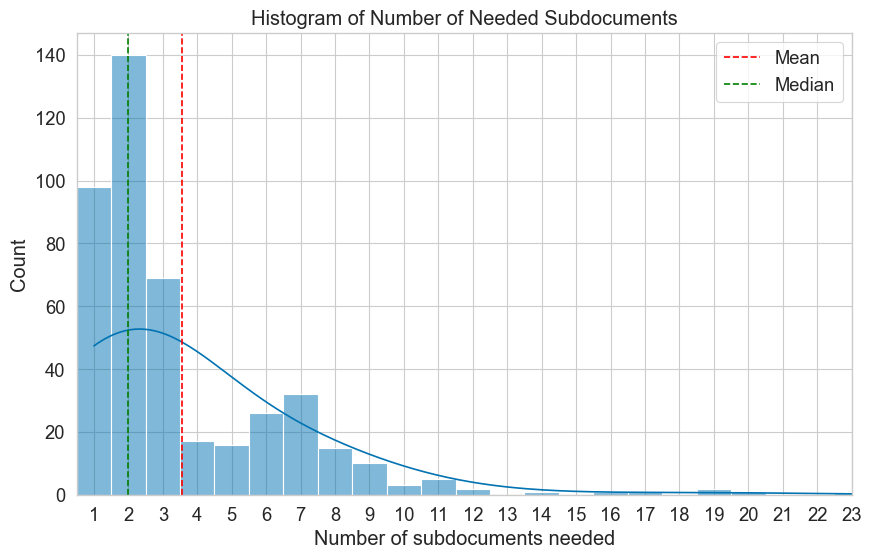

In [78]:
sns.set_theme(style="whitegrid")
sns.set_context("paper", font_scale=1.5)
sns.set_palette("colorblind")

fig, ax = plt.subplots(figsize=(10, 6))

x = prediction_stats['num_subdocs'].value_counts().sort_index().index
y = prediction_stats['num_subdocs'].value_counts().sort_index().values

max_subdocs = max(x)

# add a 0 for each number of subdocs up to the maximum number of subdocs, so that there is a value for each number of subdocs
for i in range(1, max_subdocs+1):
    if i not in x:
        x = np.append(x, i)
        y = np.append(y, 0)

sns.histplot(x=x, weights=y, discrete=True, ax=ax, kde=True)

ax.set(xticks=x)
ax.set_xlim(0.5, max_subdocs)

ax.axvline(x=np.average(x, weights=y), color='red', linestyle='--', label="Mean")

# median calculated manually
z = []
for i in range(len(x)):
    z.extend([x[i]] * y[i])

ax.axvline(x=np.median(z), color='green', linestyle='--', label="Median")

ax.set(xlabel="Number of subdocuments needed")
ax.legend()
ax.set_title("Histogram of Number of Needed Subdocuments")

plt.show()
fig.savefig("plots/subdoc_hist.png", dpi=300)


{1: 1290, 2: 998, 5: 136, 4: 218, 3: 402, 11: 19, 7: 128, 8: 56, 10: 12, 6: 141, 0: 80, 9: 25, 13: 4, 12: 5, 16: 2, 15: 3, 20: 1}


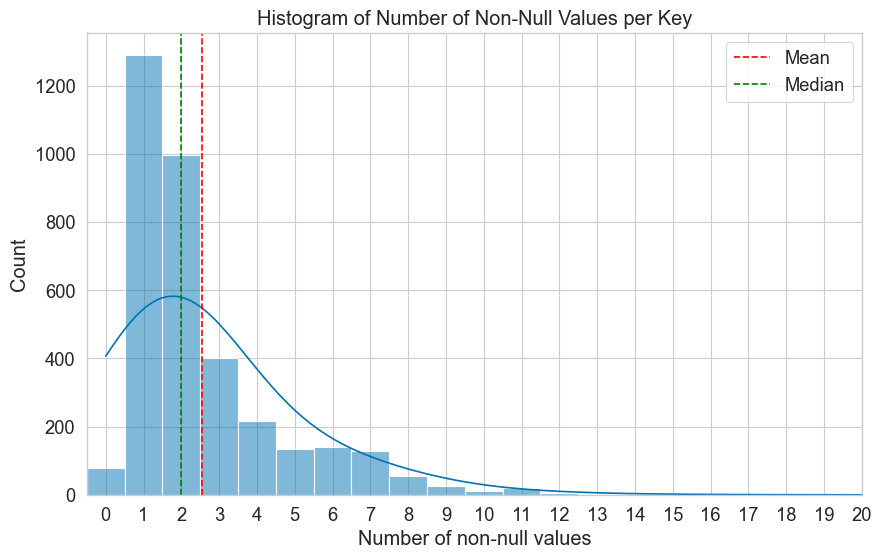

In [76]:
non_null_values_per_key = {}

for i in range(len(prediction_stats)):
    for key, value in prediction_stats.iloc[i]['num_non_null_values_per_key'].items():
        if key in non_null_values_per_key:
            non_null_values_per_key[key].append(value)
        else:
            non_null_values_per_key[key] = [value]

fig, ax = plt.subplots(figsize=(10, 6))

occurence_dict = {}
for key, values in non_null_values_per_key.items():
    for value in values:
        if value in occurence_dict:
            occurence_dict[value] += 1
        else:
            occurence_dict[value] = 1

# intersperse keys that are missing with value 0
for i in range(0, max(occurence_dict.keys())+1):
    if i not in occurence_dict:
        occurence_dict[i] = 0

# sort the dictionary by the key (number of unifications)
occurence_dict = dict(sorted(occurence_dict.items(), key=lambda item: item[0]))

x = list(occurence_dict.keys())
y = list(occurence_dict.values())

sns.histplot(x=x, weights=y, discrete=True, ax=ax, kde=True)

ax.axvline(x=np.average(x, weights=y), color='red', linestyle='--', label="Mean")

# median calculated manually
z = []
for i in range(len(x)):
    z.extend([x[i]] * y[i])

ax.axvline(x=np.median(z), color='green', linestyle='--', label="Median")

ax.set(xticks=x)
ax.set_xlim(-0.5, max(x))
ax.set(xlabel="Number of non-null values")
ax.set_title("Histogram of Number of Non-Null Values per Key")
ax.legend()

plt.show()
fig.savefig("plots/non_null_values_vs_occurence.png", dpi=300)

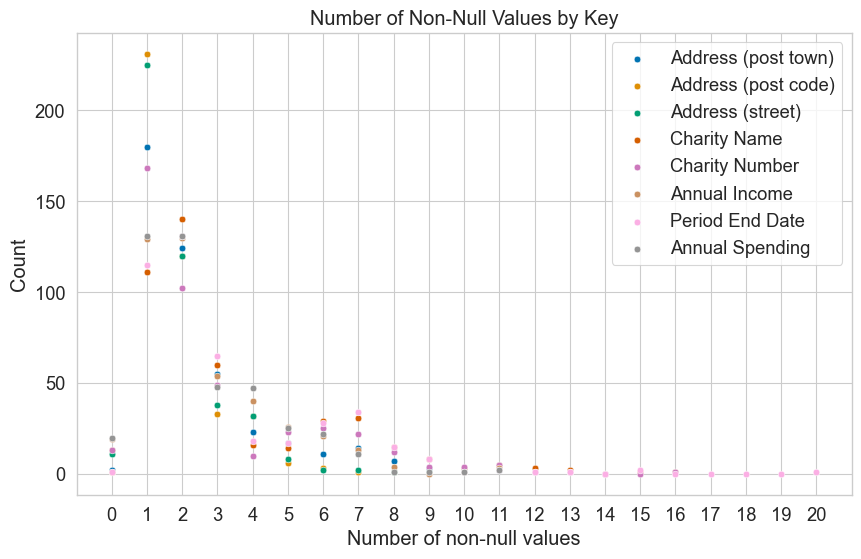

In [96]:
non_null_values_per_key = {}

for i in range(len(prediction_stats)):
    for key, value in prediction_stats.iloc[i]['num_non_null_values_per_key'].items():
        if key in non_null_values_per_key:
            non_null_values_per_key[key].append(value)
        else:
            non_null_values_per_key[key] = [value]

fig, ax = plt.subplots(figsize=(10, 6))

# one key = one bar plot (histogram)
max_val = 0
for key, values in non_null_values_per_key.items():
    occurence_dict = {}
    for value in values:
        if value in occurence_dict:
            occurence_dict[value] += 1
        else:
            occurence_dict[value] = 1

    # intersperse keys that are missing with value 0
    for i in range(0, max(occurence_dict.keys())+1):
        if i not in occurence_dict:
            occurence_dict[i] = 0

    # sort the dictionary by the key (number of unifications)
    occurence_dict = dict(sorted(occurence_dict.items(), key=lambda item: item[0]))

    x = list(occurence_dict.keys())
    y = list(occurence_dict.values())
    
    ax = sns.scatterplot(x=x, y=y, ax=ax, label=key)
    max_val = max(max_val, max(x))

ax.set(xlabel="Number of non-null values", ylabel="Count")

# set the x-ticks to be integers
ax.set_xticks(np.arange(0, max_val+1, 1))
ax.legend()
ax.set_title("Number of Non-Null Values by Key")

plt.show()
fig.savefig("plots/non_null_values_by_key_vs_count.png", dpi=300)

/Users/ivo/Library/Caches/pypoetry/virtualenvs/uni-kie-JrmAaldC-py3.8/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/ivo/Library/Caches/pypoetry/virtualenvs/uni-kie-JrmAaldC-py3.8/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


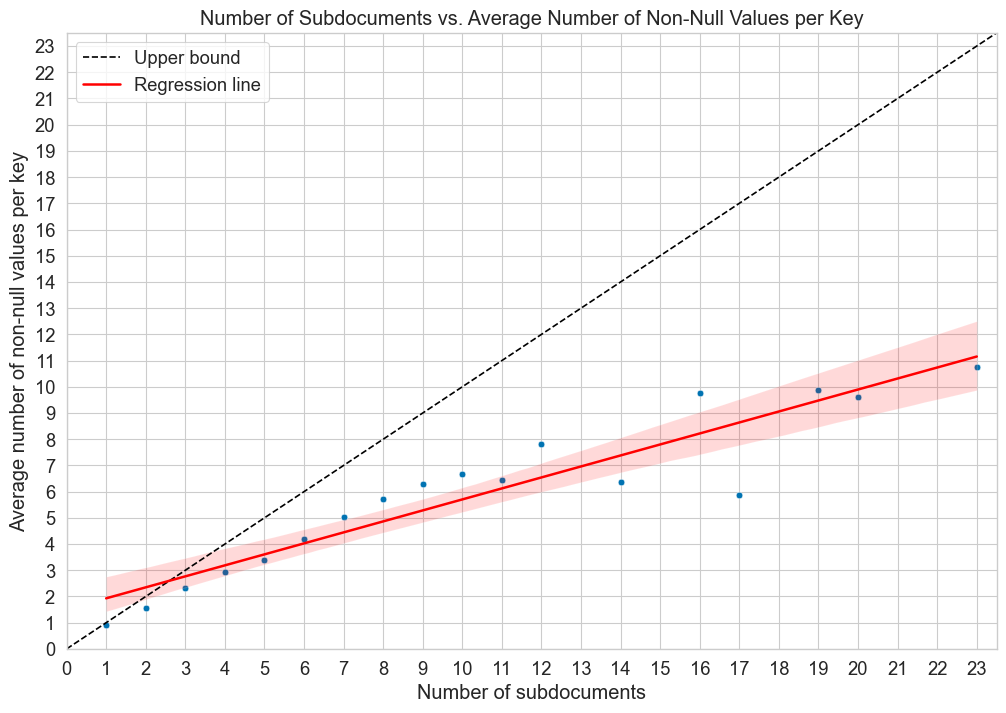

Correlation coefficient: 0.937


In [94]:
fig, ax = plt.subplots(figsize=(12, 8))

max_subdocs = max(prediction_stats['num_subdocs'])

x = np.arange(0, max_subdocs+1)
y = [] # number of non-null values per key (average over all keys)

y = [[] for _ in range(max(x)+1)]

for i in range(len(prediction_stats)):
    num_subdocs = prediction_stats.iloc[i]['num_subdocs']


    num_non_null_values = 0
    num_keys = 0
    for key, value in prediction_stats.iloc[i]['num_non_null_values_per_key'].items():
        num_non_null_values += value
        num_keys += 1
    if num_keys > 0:
        y[num_subdocs].append(num_non_null_values / num_keys)
    else:
        y[num_subdocs].append(0)

y = [np.mean(y[i]) for i in range(len(y))] # average number of non-null values per key for each number of subdocuments

ax.plot([0, max(x) + 1], [0, max(x) + 1], color='black', linestyle='--', label='Upper bound')

ax = sns.scatterplot(x=x, y=y, ax=ax)

sns.regplot(x=x, y=y, ax=ax, scatter=False, color='red', label='Regression line')

ax.set(xticks=x, yticks=x)
ax.set_xlim(left=0)
ax.set_ylim(bottom=0)
ax.set_xlim(right=max_subdocs+0.5)
ax.set_ylim(top=max_subdocs+0.5)

# remove nan values from x and y
x = [x[i] for i in range(len(x)) if not np.isnan(y[i])]
y = [y[i] for i in range(len(y)) if not np.isnan(y[i])]


ax.set(xlabel="Number of subdocuments", ylabel="Average number of non-null values per key")
ax.legend(loc='upper left')
ax.set_title("Number of Subdocuments vs. Average Number of Non-Null Values per Key")

plt.show()
fig.savefig("plots/num_subdocs_vs_non_null_values_per_key.png", dpi=300)

print("Correlation coefficient: " + str(round(np.corrcoef(x, y)[0, 1], 3)))

In [99]:
x = []
y = []

for key, values in non_null_values_per_key.items():
    x.append(key)
    y.append(sum(values)/len(values))

# round to 2 decimal places
y = [round(y[i], 2) for i in range(len(y))]

# create a table with the keys and the average number of non-null values per key
key_stats = pd.DataFrame({'key': x, 'avg_num_of_non_null_values': y})

print(key_stats) # avg_num_of_non_null_values is the average number of non-null values per key
print(lenient_accuracy_by_key) # lenient_accuracy_by_key is the accuracy for each key

# what's the correlation between those two?
print("Correlation coefficient: " + str(round(np.corrcoef(key_stats['avg_num_of_non_null_values'], lenient_accuracy_by_key)[0, 1], 3)))

                   key  avg_num_of_non_null_values
0  Address (post town)                        2.41
1  Address (post code)                        1.73
2     Address (street)                        1.80
3         Charity Name                        3.33
4       Charity Number                        2.83
5        Annual Income                        2.58
6      Period End Date                        3.26
7      Annual Spending                        2.52
   Address (post town)  Address (post code)  Address (street)  Charity Name  \
0             0.830409             0.704678          0.374269      0.619883   

   Charity Number  Annual Income  Period End Date  Annual Spending  
0        0.964912       0.587719         0.988304         0.602339  
Correlation coefficient: 0.507


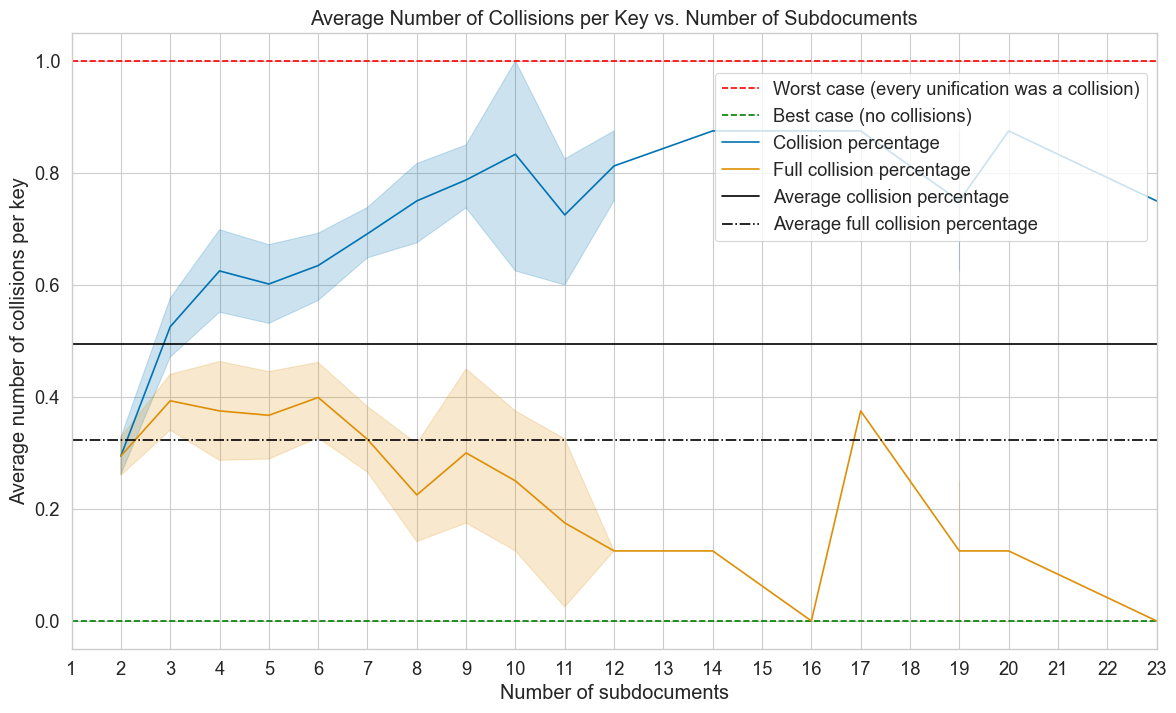

In [91]:
sns.set_theme(style="whitegrid")
sns.set_context("paper", font_scale=1.5)
sns.set_palette("colorblind")

fig, ax = plt.subplots(figsize=(14, 8))

ax.axhline(y=1, color="red", linestyle="--", label="Worst case (every unification was a collision)")
ax.axhline(y=0, color="green", linestyle="--", label="Best case (no collisions)")

ax = sns.lineplot(x="num_subdocs", y="collision_percentage", data=prediction_stats, ax=ax, label="Collision percentage")
ax = sns.lineplot(x="num_subdocs", y="full_collision_percentage", data=prediction_stats, ax=ax, label="Full collision percentage")

avg_collision_percentage = np.nanmean(prediction_stats['collision_percentage'])
ax.axhline(y=avg_collision_percentage, color="black", linestyle="-", label="Average collision percentage")

avg_full_collision_percentage = np.nanmean(prediction_stats['full_collision_percentage'])
ax.axhline(y=avg_full_collision_percentage, color="black", linestyle="-.", label="Average full collision percentage")

ax.set_xlim(left=1, right=max(prediction_stats['num_subdocs']))
ax.set(xticks=np.arange(1, max_subdocs+1, 1))
ax.set(xlabel="Number of subdocuments", ylabel="Average number of collisions per key", title="Average Number of Collisions per Key vs. Number of Subdocuments")
ax.legend(loc='upper right', bbox_to_anchor=(1.0, 0.95))

plt.show()

fig.savefig("plots/collisions_wrt_subdocs_hist.png", dpi=300)

1 subdocument == no subdocs (or in other words: the 1 subdoc is the whole document)

Note: best case assumes:
* perfect OCR
* no mistakes in the reports (no typos, no conflicting information on different pages)

of course with num_subdocs=2 every collision is a full_collision :) 

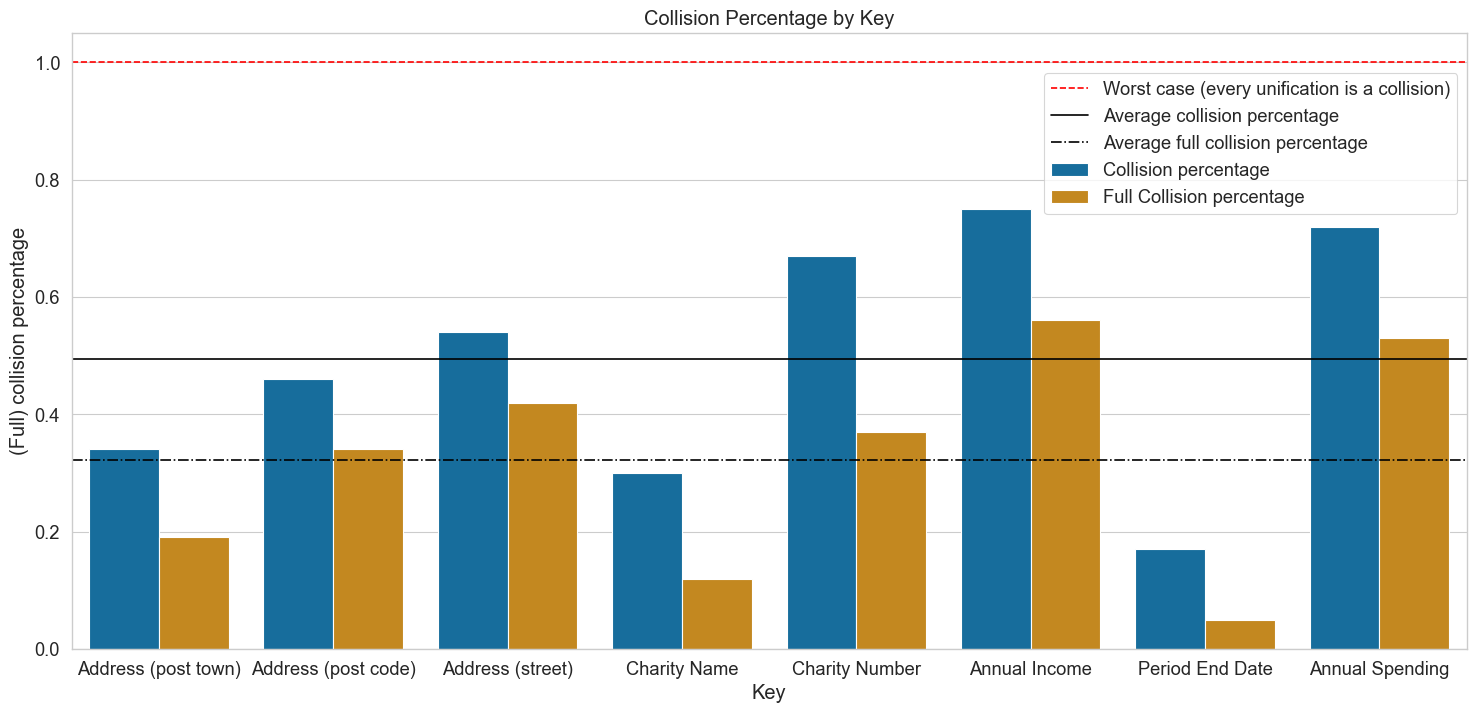

In [126]:
sns.set_theme(style="whitegrid")
sns.set_context("paper", font_scale=1.5)
sns.set_palette("colorblind")

fig, ax = plt.subplots(figsize=(18, 8))

ax.axhline(y=1, color="red", linestyle="--", label="Worst case (every unification is a collision)")

collision_percentage_by_key = {}
full_collision_percentage_by_key = {}

# line plot of the collision percentage by key
for key in prediction_stats['num_unified_values_per_key'].iloc[0].keys():
    for i in range(len(prediction_stats)):
        if key not in collision_percentage_by_key:
            collision_percentage_by_key[key] = []

        if key not in full_collision_percentage_by_key:
            full_collision_percentage_by_key[key] = []

        collision_percentage_by_key[key].append(prediction_stats['collision_per_key'].iloc[i][key])
        full_collision_percentage_by_key[key].append(prediction_stats['full_collision_per_key'].iloc[i][key])

# filter out None values
collision_percentage_by_key = {key: [x for x in collision_percentage_by_key[key] if x is not None] for key in collision_percentage_by_key.keys()}
full_collision_percentage_by_key = {key: [x for x in full_collision_percentage_by_key[key] if x is not None] for key in full_collision_percentage_by_key.keys()}

# calculate average and ignore nan values and round to 2 decimal places
collision_percentage_by_key = {key: round(np.nanmean(collision_percentage_by_key[key]), 2) for key in collision_percentage_by_key.keys()}
full_collision_percentage_by_key = {key: round(np.nanmean(full_collision_percentage_by_key[key]), 2) for key in full_collision_percentage_by_key.keys()}

# add those values to the dataframe
key_stats['collision_percentage'] = key_stats['key'].map(collision_percentage_by_key)
key_stats['full_collision_percentage'] = key_stats['key'].map(full_collision_percentage_by_key)

# create a barplot that has grouped bars

# we want to use the "hue" parameter to group the bars by collision vs. full collision
# thus we have to transform the dataframe to have a column for each of the two types of collisions
# and a column for the key
key_stats_trf = key_stats.melt(id_vars=['key'], value_vars=['collision_percentage', 'full_collision_percentage'], var_name='collision_type', value_name='collision_pct')

# rename the collision types to something more readable
key_stats_trf['collision_type'] = key_stats_trf['collision_type'].map({'collision_percentage': 'Collision percentage', 'full_collision_percentage': 'Full Collision percentage'})

# create the barplot
ax = sns.barplot(x="key", y="collision_pct", hue="collision_type", data=key_stats_trf, ax=ax)

avg_collision_percentage = np.nanmean(list(collision_percentage_by_key.values()))
ax.axhline(y=avg_collision_percentage, color="black", linestyle="-", label="Average collision percentage")

avg_full_collision_percentage = np.nanmean(list(full_collision_percentage_by_key.values()))
ax.axhline(y=avg_full_collision_percentage, color="black", linestyle="-.", label="Average full collision percentage")

ax.set(xlabel="Key", ylabel="(Full) collision percentage", title="Collision Percentage by Key")
ax.legend(loc='upper right', bbox_to_anchor=(1.0, 0.95))

plt.show()
fig.savefig("plots/collision_percentage_by_key.png", dpi=300)

In [105]:
key_stats

,key,avg_num_of_non_null_values,collision_percentage,full_collision_percentage
0,Address (post town),2.41,0.34,0.19
1,Address (post code),1.73,0.46,0.34
2,Address (street),1.80,0.54,0.42
3,Charity Name,3.33,0.30,0.12
4,Charity Number,2.83,0.67,0.37
5,Annual Income,2.58,0.75,0.56
6,Period End Date,3.26,0.17,0.05
7,Annual Spending,2.52,0.72,0.53


In [35]:
# calculate the part of collisions that are full collisions
key_stats['full_collision_over_collision'] = round(key_stats['full_collision_percentage'] / key_stats['collision_percentage'], 2)

In [36]:
key_stats

,key,avg_num_unified_values,collision_percentage,full_collision_percentage,full_collision_over_collision
0,Address (post town),2.82,0.34,0.19,0.56
1,Address (post code),1.99,0.46,0.34,0.74
2,Address (street),2.06,0.54,0.42,0.78
3,Charity Name,4.00,0.30,0.12,0.40
4,Charity Number,3.41,0.67,0.37,0.55
5,Annual Income,3.09,0.75,0.56,0.75
6,Period End Date,3.91,0.17,0.05,0.29
7,Annual Spending,3.02,0.72,0.53,0.74


In [37]:
# visualize the dataframe key_stats with a heatmap
fig, ax = plt.subplots(figsize=(18, 8))

# create a heatmap ignore 'key' column
sns.heatmap(key_stats.iloc[:, 2:], annot=True, fmt=".2f", cmap="YlGnBu", ax=ax)

ax.set(xlabel="Key", ylabel="Collision type", title="Collision statistics by key")

plt.show()

KeyboardInterrupt: 

# Baseline Evaluation
In order to contextualize the performance of the baselines (general and specific), we want to check how often the key search (with the given fuzziness) yields any result. In case of the general baseline, if no match is found then no key-value is extracted, in case of the specific baseline there is the addition of synonyms for some of the keys which increases the likelihood of finding a key in the doc.

In [ ]:
in_df = pd.read_csv("datasets/kleister_charity/dev-0/in_extended.tsv", sep="\t")

In [ ]:
prompt_key_to_gold_key = {
    "Address (post code)": "address__postcode",
    "Address (street)": "address__street_line",
    "Address (post town)": "address__post_town",
    "Charity Name": "charity_name",
    "Charity Number": "charity_number",
    "Annual Income": "income_annually_in_british_pounds",
    "Period End Date": "report_date",
    "Annual Spending": "spending_annually_in_british_pounds",
}
prompt_keys = list(prompt_key_to_gold_key.keys())
gold_keys = list(prompt_key_to_gold_key.values())

# for specific baseline we also use these synonyms
synonyms = {
    "Charity Name": ["Charity Name"],
    "Charity Number": [
        "Charity Number",
        "Charity Registration No",
        "Charity No",
    ],
    "Annual Income": ["Annual Income", "Income", "Total Income"],
    "Period End Date": ["Period End Date", "Period End", "Year Ended"],
    "Annual Spending": [
        "Annual Spending",
        "Spending",
        "Total Spending",
        "Expenditure",
    ],
}

# create dict that will record how often the respective key was actually found
key_to_count = {key: 0 for key in prompt_keys}

total = 0

In [ ]:
# NOTE: this has to match the respective configuration of the baseline model that is evaluated
type_of_baseline = "specific" # or "specific" 
error_percentage = 0.18

def get_best_match_span(text: str, key: str):
    """
    Returns the best match for the key in the text with some fuzziness
    (i.e. we limit the levenshtein distance) of the best match.

    (?b) -> BESTMATCH
    (?i) -> IGNORECASE
    {e<n} -> up to n errors (subs, inserts, dels). if more -> None
    (1) -> the span of the best match
    """
    key_length = len(key)
    max_errors = round(key_length * error_percentage)
    match_span = regex.search(f"(?b)(?i)({key}){{e<{max_errors}}}", text)

    if match_span:
        return match_span.span(1)

In [ ]:
for i in range(len(in_df)):
    text = in_df.loc[in_df["filename"] == in_df.iloc[i]["filename"], "text_best_cleaned"].values[0]

    if type_of_baseline == "general":
        # check for a match for each key
        for i, key in enumerate(prompt_keys):
            total += 1
            match_span = get_best_match_span(text, key)

            if match_span is None:
                continue
            else:
                key_to_count[key] += 1
    
    elif type_of_baseline == "specific":
        # check for a match for each synonym
        for i, key in enumerate(list(synonyms.keys())):
            total += 1
            for synonym in synonyms[key]:
                match_span = get_best_match_span(text, synonym)
    
                if match_span is None: # no match for this synonym
                    continue
                else:
                    key_to_count[key] += 1 # found a match for this key
                    break # no need to check the other synonyms for this key as we are only interested if any of them matches


In [ ]:
if type_of_baseline == "specific":
    num_keys_considered = len(synonyms.keys())

    # remove the keys that we don't use synonyms for
    for key in prompt_keys:
        if key not in synonyms.keys():
            key_to_count.pop(key)
else:
    num_keys_considered = len(prompt_keys)


key_to_count_percentage = {key: count / total * num_keys_considered * 100 for key, count in key_to_count.items()}
print(key_to_count_percentage)

# macro average
print(f"(macro)[over keys] average Percentage of how often the keys can be found in the docoument: {sum(key_to_count_percentage.values()) / len(key_to_count_percentage)}")

# micro average
print(f"(micro)[over all predictions] average Percentage of how often the keys can be found in the document: {sum(key_to_count.values()) / total * 100}")

# they are the same which makes sense because all classes (keys) are checked the same amount of times